In [27]:
import os
import sys
import cv2
from math import pi
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from equi2pers_v3 import equi2pers
from pers2equi_v3 import pers2equi
import torchvision

In [28]:
encoder = torchvision.models.resnet18(pretrained=True)
weights = encoder.conv1.weight.data
bias = encoder.conv1.bias


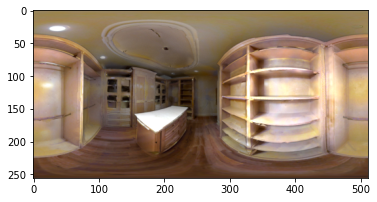

In [29]:
img = cv2.imread('pano4.png', cv2.IMREAD_COLOR)
#img = img.astype(np.float32) / 255
[erp_h, erp_w, _] = img.shape
plt.imshow(img[:,:,[2,1,0]])
plt.show()

In [30]:
img_new = img.astype(np.float32) / 255
img_new = np.transpose(img_new, [2, 0, 1])
img_new = torch.from_numpy(img_new)
img_new = img_new.unsqueeze(0)

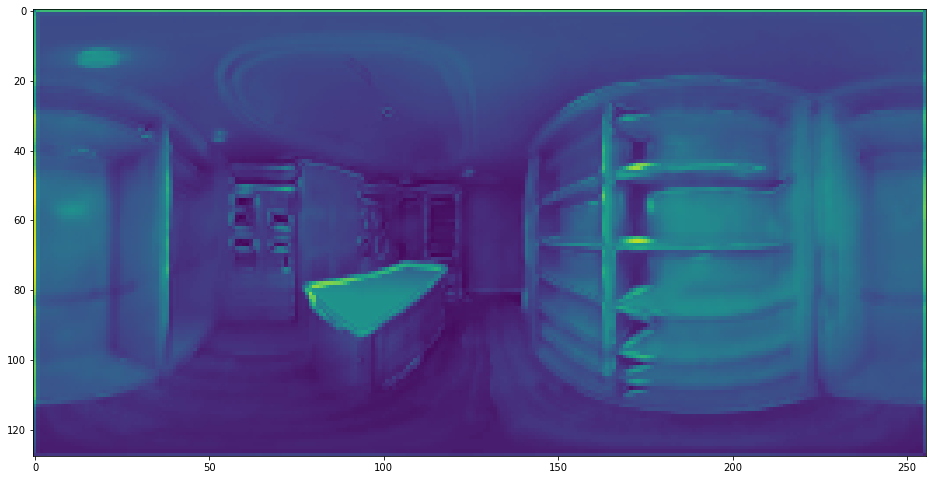

In [31]:
regular_conv_out = encoder.conv1(img_new)
regular_conv_out = regular_conv_out[0].permute(1, 2, 0).detach().numpy()
regular_conv_out = regular_conv_out.max(-1)
plt.figure(figsize=(16, 12))
plt.imshow(regular_conv_out, aspect=1)
plt.show()

In [32]:
patch_size = 80
fov = (52, 52)
pers = equi2pers(img_new, fov, patch_size)
pers_w = pers.shape[-1]
unfold = F.unfold(pers, kernel_size=(patch_size, patch_size), stride=(patch_size, patch_size))
unfold_reshape = unfold.reshape(1, 3, patch_size, patch_size, -1)
print(unfold.shape)
print(unfold_reshape.shape)

torch.Size([1, 19200, 46])
torch.Size([1, 3, 80, 80, 46])


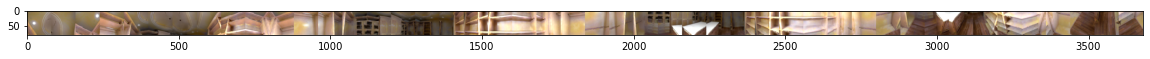

In [33]:
persp_int = pers[0].permute(1, 2, 0).numpy()
persp_int = persp_int * 255
plt.figure(figsize=(20, 12))
plt.imshow(persp_int[:,:,[2,1,0]].astype(np.uint8), aspect=1)
plt.show()

torch.Size([80, 80, 3])


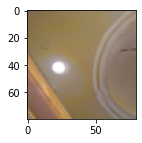

In [34]:
patch = unfold_reshape[0, :, :, :, 0].permute(1, 2, 0)
print(patch.shape)
plt.figure(figsize=(2, 2))
plt.imshow(patch[:,:,[2,1,0]], aspect=1)
plt.show()

In [35]:
weights = weights.unsqueeze(-1)
print(unfold_reshape.shape)
print(weights.shape)
pad_img = F.pad(unfold_reshape, (0, 0, 3, 3, 3, 3), 'replicate')
print(pad_img.shape)
conv_out = F.conv3d(pad_img, weights, stride=(2, 2, 1))
conv_out = conv_out.reshape(1, -1, unfold_reshape.shape[-1])
print(conv_out.shape)


torch.Size([1, 3, 80, 80, 46])
torch.Size([64, 3, 7, 7, 1])
torch.Size([1, 3, 86, 86, 46])
torch.Size([1, 102400, 46])


In [36]:
fold = F.fold(conv_out, output_size=(patch_size//2, pers_w//2), kernel_size=patch_size//2, stride=patch_size//2)
print(fold.shape)

torch.Size([1, 64, 40, 1840])


(40, 1840)


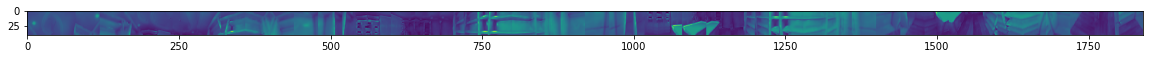

In [37]:
fold_int = fold[0].permute(1, 2, 0).numpy()
fold_int = fold_int.max(-1)
print(fold_int.shape)
plt.figure(figsize=(20, 12))
plt.imshow(fold_int, aspect=1)
plt.show()

In [38]:
equi_output = pers2equi(fold, fov, patch_size=patch_size//2, erp_size=(128, 256))

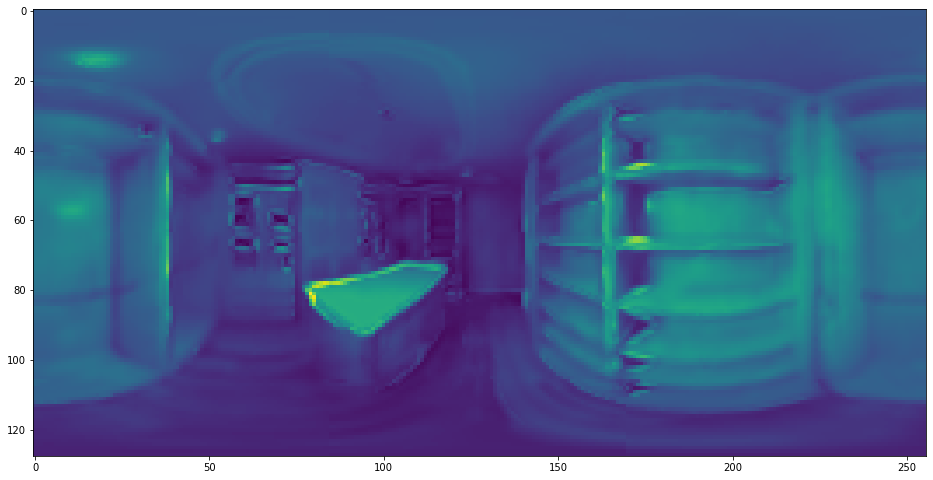

In [39]:
equi_output_int = equi_output[0].permute(1, 2, 0).numpy()
equi_output_int = equi_output_int.max(-1)
plt.figure(figsize=(16, 12))
plt.imshow(equi_output_int, aspect=1)
plt.show()